In [1]:
from qiskit import *
from qiskit.circuit.library import MCXGate

In [ ]:
def get_sat() -> tuple[int, list[list[int]]]:
    """
    To enter the clause type all the literals present in the clause separated by comma,
    if the literal is negated enter a `-` sign in front of it.
    ex: 1,3,-4 is the clause (X1 V X3 V ¬X4)
    """
    x = int(input("Enter the ammount of literals: "))
    cnf = []
    while True:
        clause = list(map(int, input("Enter a clause").split(",")))
        if clause[0] == 0:
            break
        else:
            cnf.append(clause)
    return (x, cnf)

print(get_sat())

In [2]:
def sat_clause_control_string(l: list[int]) -> str:
    c_string = ""
    for i in l:
        if i > 0:
            c_string += "0"
        else:
            c_string += "1"
    return c_string[::-1]

print(sat_clause_control_string([2, -4, -5]))

110


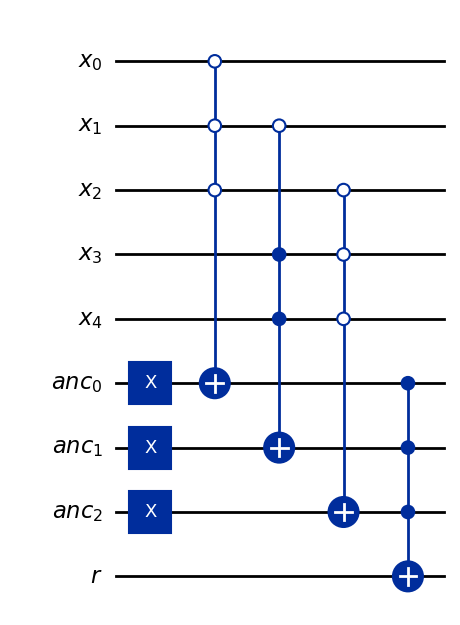

In [4]:
def sat_UF(sat_x: int, sat_clauses: list[list[int]]) -> QuantumCircuit:
    x = QuantumRegister(sat_x, "x")
    anc = QuantumRegister(len(sat_clauses), "anc")
    r = QuantumRegister(1, "r")
    quantum_circuit = QuantumCircuit(x,anc,r,name="SAT-UF")
    quantum_circuit.x(anc)
    for i in range(len(sat_clauses)):
        c_string = sat_clause_control_string(sat_clauses[i])
        clause_i = MCXGate(len(sat_clauses[i]), ctrl_state=c_string)
        indexes = list(map(lambda a: abs(a)-1, sat_clauses[i]))
        quantum_circuit.append(clause_i, indexes + anc[i:i+1])
    quantum_circuit.append(MCXGate(len(sat_clauses)), anc[:] + r[:])
    return quantum_circuit

circ = sat_UF(5, [[1, 2, 3], [2, -4, -5], [3, 4, 5]])
circ.draw("mpl")


In [ ]:
def groover(bit_array: list[int], UF: QuantumCircuit) -> QuantumCircuit:
    """
    bit array is the array that contains the how many bits will be used in witch register
    [5,3,1] means 5 input bits, 3 anc bits and 1 result bit.
    """
    return